In [ ]:
# default_exp utils

In [ ]:
#export
from sensorai.imports import *
from sensorai.tf_imports import *

In [ ]:
#hide
from nbdev.showdoc import *

# Utility Belts
> Contain some common helper functions

## 1% Better Everyday

# Math 

In [ ]:
#export
def moving_average(x, window=5):
    """
    Return a moving-window average.
    :param x: a numpy array
    :param window: an integer, number of data points for window size.
    """
    return (pd.DataFrame(x)
                .rolling(window=window, min_periods=1)
                .mean()
                .values
                .squeeze())

In [ ]:
x = np.arange(10)
test_eq(moving_average(x), [0.,0.5,1.,1.5,2.,3.,4.,5.,6.,7.])
test_eq(moving_average(x,4), [0.,0.5,1.,1.5,2.5,3.5,4.5,5.5,6.5,7.5])

## PCA

Principal Component Analysis (PCA) is mainly to intuitively understand what is going on with the data. It is mainly used in visualizing and analyzing the data.

In our case we have 13 dimensional latent factors to understand a wine. Which is hard for us humans to get proper picture of. So, what we do is we merge this 13 dimensions down to 3 and plot them on graph to classify which movies belongs to which dimension and get proper look at each of them. That way, its much easier for us to understand the latent factors that was collected.

So, in other words, PCA extracts out or lets us give out major factors which is influential to the data from many factors or dimensions in our case. Out of 13 components, we boil down to 3 major principal components to analyze our data.

In [ ]:
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
df = pd.read_csv(URL, header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
x = tf.convert_to_tensor(df.iloc[:,1:].values)
y = tf.convert_to_tensor(df.iloc[:,0].values)

In [ ]:
x_mean = tf.math.reduce_mean(x,axis=0)
x_std = tf.math.reduce_std(x,axis=0)

In [ ]:
xn = (x-x_mean[None,]) / x_std[None,]

In [ ]:
cov_mat = np.cov(xn.numpy().T)

In [ ]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

In [ ]:
eigen_vals

array([4.73243698, 2.51108093, 1.45424187, 0.92416587, 0.85804868,
       0.64528221, 0.55414147, 0.10396199, 0.35046627, 0.16972374,
       0.29051203, 0.22706428, 0.25232001])

In [ ]:
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]

In [ ]:
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.36198848, 0.55406338, 0.66529969, 0.73598999, 0.80162293,
       0.85098116, 0.89336795, 0.92017544, 0.94239698, 0.96169717,
       0.97906553, 0.99204785, 1.        ])

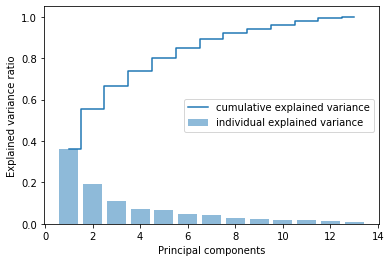

In [ ]:
plt.bar(range(1,14), var_exp, alpha=.5, label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')

In [ ]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
               for i in range(len(eigen_vals))]

In [ ]:
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

In [ ]:
w = np.hstack((eigen_pairs[0][1]))

In [ ]:
eigen_pairs[0][1], eigen_pairs[1][1]

(array([-0.1443294 ,  0.24518758,  0.00205106,  0.23932041, -0.14199204,
        -0.39466085, -0.4229343 ,  0.2985331 , -0.31342949,  0.0886167 ,
        -0.29671456, -0.37616741, -0.28675223]),
 array([ 0.48365155,  0.22493093,  0.31606881, -0.0105905 ,  0.299634  ,
         0.06503951, -0.00335981,  0.02877949,  0.03930172,  0.52999567,
        -0.27923515, -0.16449619,  0.36490283]))

In [ ]:
w = np.stack([eigen_pairs[0][1], eigen_pairs[1][1]], axis=1)

In [ ]:
xn[0].numpy().dot(w)

array([-3.31675081,  1.44346263])

In [ ]:
xpca = xn.numpy().dot(w)

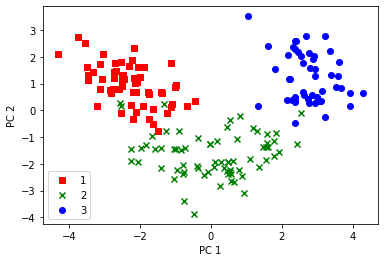

In [ ]:
colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']
for l,c,m in zip(np.unique(y.numpy()), colors, markers):
    plt.scatter(xpca[y.numpy()==l, 0],
                xpca[y.numpy()==l, 1],
                c=c, label=l, marker=m)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc='lower left')

In [ ]:
#export
def _pca(x, k=2):
    x = x-tf.math.reduce_mean(x,axis=0)
    S,U,V = tf.linalg.svd(tf.transpose(x))
    return tf.matmul(x,U[:,:k])

In [ ]:
xsvd = _pca(xn).numpy()*(-1)

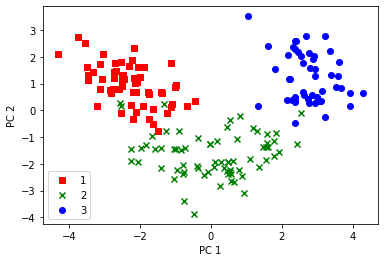

In [ ]:
colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']
for l,c,m in zip(np.unique(y.numpy()), colors, markers):
    plt.scatter(xsvd[y.numpy()==l, 0],
                xsvd[y.numpy()==l, 1],
                c=c, label=l, marker=m)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc='lower left')

In [ ]:
test_close((xpca-xsvd).mean(),0)